In [1]:
from helper import *
import logging
from albumentations.pytorch import ToTensorV2
from multiprocessing import Pool, set_start_method
import albumentations as A
import timm
from datetime import datetime
from itertools import cycle
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import matthews_corrcoef, accuracy_score
import os
import numpy as np
import pandas as pd
import random
import cv2
from math import ceil
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
CFG = {
    'seed': 42,
    'test_size': 1000,
    'lr': 1,
    'use_multi': False,
    'num_workers': 8,
    'batch_size': 64,
    'iterations': 1,
    'val_wait': 1,
    'scheduler_patience': 100,
    'saver_mode': 'all',
    'es_patience': 2,
    'rop_factor': 0.5,
    'rop_patience': 100,
}


In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])

In [4]:
%%time
df = pd.read_csv('./final_data2.csv')
df['bbox_endzone'] = df['bbox_endzone'].apply(process_bbox)
df['bbox_sideline'] = df['bbox_sideline'].apply(process_bbox)

CPU times: user 52.4 s, sys: 696 ms, total: 53.1 s
Wall time: 53.5 s


In [17]:
categorical_data_for_fitting = [
    ['home', 'CB', 'home', 'CB', ] ,
    ['home', 'DE', 'home', 'DE', ],
    ['home', 'FS', 'home', 'FS', ],
    ['home', 'TE', 'home', 'TE', ] ,
    ['home', 'ILB', 'home', 'ILB', ],
    ['home', 'OLB', 'home', 'OLB', ],
    ['home', 'T', 'home', 'T', ],
    ['home', 'G', 'home', 'G', ] ,
    ['home', 'C', 'home', 'C', ] ,
    ['home', 'QB', 'home', 'QB', ],
    ['home', 'WR', 'home', 'WR', ],
    ['home', 'RB', 'home', 'RB', ],
    ['home', 'NT', 'home', 'NT', ],
    ['home', 'DT', 'home', 'DT', ],
    ['home', 'MLB', 'home', 'MLB', ],
    ['home', 'SS', 'home', 'SS', ] ,
    ['home', 'OT', 'home', 'OT', ],
    ['home', 'LB', 'home', 'LB', ],
    ['home', 'OG', 'home', 'OG', ] ,
    ['home', 'SAF', 'home', 'SAF', ],
    ['home', 'DB', 'home', 'DB', ] ,
    ['home', 'LS', 'home', 'LS', ] ,
    ['home', 'K', 'home', 'K', ],
    ['home', 'P', 'home', 'P', ],
    ['home', 'FB', 'home', 'FB', ] ,
    ['home', 'S', 'home', 'S', ],
    ['home', 'DL', 'Ground', 'DL', ],
    ['away', 'HB', 'away', 'HB', ],
    ['away', 'HB', 'away', 'Ground', ],
]
    
one_hot = OneHotEncoder()
one_hot.fit(categorical_data_for_fitting)

OneHotEncoder()

In [18]:
one_hot.transform(categorical_data_for_fitting).toarray()

a = np.array(categorical_data_for_fitting)
a.shape

(29, 4)

In [19]:
df_G1 = df.loc[(df['contact'] == 1) & (df['G_flug'] == True)]
df_G0 = df.loc[(df['contact'] == 0) & (df['G_flug'] == True)]
df_P1 = df.loc[(df['contact'] == 1) & (df['G_flug'] == False)]
df_P0 = df.loc[(df['contact'] == 0) & (df['G_flug'] == False)]


In [20]:
random_state = 42

train_G1, test_G1 = train_test_split(
    df_G1, test_size=CFG['test_size']//4, random_state=random_state)
train_G0, test_G0 = train_test_split(
    df_G0, test_size=CFG['test_size']//4, random_state=random_state)
train_P1, test_P1 = train_test_split(
    df_P1, test_size=CFG['test_size']//4, random_state=random_state)
train_P0, test_P0 = train_test_split(
    df_P0, test_size=CFG['test_size']//4, random_state=random_state)


In [21]:
def read_image(path, cx, cy, view, aug):
    img_new = np.zeros((1, 256, 256), dtype=np.float32)
    if os.path.isfile(path):
        if view == 'Endzone':
            img = cv2.imread(path, 0)[
                cy-76:cy+180, cx-128:cx+128].copy()
            img_new[0, :img.shape[0], :img.shape[1]] = img
        else:
            img = cv2.imread(path, 0)[
                cy-128:cy+128, cx-128:cx+128].copy()
            img_new[0, :img.shape[0], :img.shape[1]] = img
    return aug(image=img_new.transpose(1, 2, 0))['image'][0]

In [22]:
class MyDataset(Dataset):
    def __init__(self, df1, df2, df3, df4, aug, one_hot_transform, train=True, feature_cols=['rel_pos_x',
                                                                                                     'rel_pos_y', 'rel_pos_mag', 'rel_pos_ori', 'rel_speed_x', 'rel_speed_y',
                                                                                                     'rel_speed_mag', 'rel_speed_ori', 'rel_acceleration_x',
                                                                                                     'rel_acceleration_y', 'rel_acceleration_mag', 'rel_acceleration_ori',
                                                                                                     'G_flug', 'orientation_1', 'orientation_2']):

        self.df1 = df1
        self.df2 = df2
        self.df3 = df3
        self.df4 = df4
        # self.logger = logger
        self.features = feature_cols
        self.aug = aug
        self.train = train
        self.one_hot_transform = one_hot_transform

    def __len__(self):
        return max(len(self.df1), len(self.df2), len(self.df3), len(self.df4))//(CFG['batch_size']//4)

    def get_rows(self, lnum, unum, df_num):
        df_map = {
            1: self.df1,
            2: self.df2,
            3: self.df3,
            4: self.df4,
        }
        # self.logger.debug(f"df{df_num} with lnum:{lnum}, unum:{unum}")
        lnum = lnum % len(df_map[df_num])
        unum = unum % len(df_map[df_num])
        # self.logger.debug(f"df{df_num} with lnum:{lnum}, unum:{unum}")

        if lnum < unum:
            # self.logger.debug(f"return is {df_map[df_num][lnum:unum].shape}")
            return df_map[df_num][lnum:unum]
        else:
            # self.logger.debug(
            #     f"return is {pd.concat([df_map[df_num][lnum:], df_map[df_num][:unum]]).shape}")
            if self.train:
                return pd.concat([df_map[df_num][lnum:], df_map[df_num][:unum]])
            else:
                return df_map[df_num][lnum:]

    def normalize_features(self, features):
        """
        normalizes the features of the players

       'rel_pos_x',
       'rel_pos_y', 'rel_pos_mag', 'rel_pos_ori', 'rel_speed_x', 'rel_speed_y',
       'rel_speed_mag', 'rel_speed_ori', 'rel_acceleration_x',
       'rel_acceleration_y', 'rel_acceleration_mag', 'rel_acceleration_ori',
       'G_flug', 'orientation_1', 'orientation_2'
        """
        features /= 100
        features[3] /= 3.6
        features[7] /= 3.6
        features[11] /= 3.6
        features[13] /= 3.6
        features[14] /= 3.6
        return features

    def __getitem__(self, idx):
        window = 24
        frames_to_skip = 4

        # self.logger.debug(f"idx that is causing issue: {idx}")

        row1 = self.get_rows(
            idx*(CFG['batch_size']//4), (idx+1)*(CFG['batch_size']//4), 1).reset_index(drop=True)
        row2 = self.get_rows(
            idx*(CFG['batch_size']//4), (idx+1)*(CFG['batch_size']//4), 2).reset_index(drop=True)
        row3 = self.get_rows(
            idx*(CFG['batch_size']//4), (idx+1)*(CFG['batch_size']//4), 3).reset_index(drop=True)
        row4 = self.get_rows(
            idx*(CFG['batch_size']//4), (idx+1)*(CFG['batch_size']//4), 4).reset_index(drop=True)

        row = pd.concat([row1, row2, row3, row4]).reset_index(drop=True)
        # self.logger.debug(f"row colums: {row.columns}")
        # self.logger.debug(f"Row shape:{row.shape}")
        mid_frame = row['frame']
        # self.logger.debug(f"mid frames shape:{len(mid_frame)}")
        label = np.array(row['contact']).astype(np.float32)
        # self.logger.debug(f"label:{len(label)}")
        args = []
        for i in range(len(row)):
            for view in ['Endzone', 'Sideline']:
                # print(i)
                # print(row.iloc[i])
                video = row.iloc[i]['game_play'] + f'_{view}.mp4'
                cur_mid_frame = mid_frame.iloc[i]
                frames = [cur_mid_frame - window +
                          i for i in range(0, 2*window+1, frames_to_skip)]
                bbox_col = 'bbox_endzone' if view == 'Endzone' else 'bbox_sideline'
                # self.logger.debug(
                #     f"bbox details:\n{row.iloc[i][bbox_col][::frames_to_skip]}")
                bboxes = row.iloc[i][bbox_col][::frames_to_skip].astype(
                    np.int32)

                if bboxes.sum() <= 0:
                    args += [('dummy', 0, 0, view, self.aug)]*len(frames)
                    continue

                for frame_iter, frame in enumerate(frames):
                    cx, cy = bboxes[frame_iter]
                    path = f'./work/train_frames/{video}_{frame:04d}.jpg'
                    args.append((path, cx, cy, view, self.aug))

        # self.logger.debug(f"sizeof args:{len(args)}")
        # with Pool(CFG['num_workers']) as pool:
        #     imgs = list(pool.starmap(read_image, args))
        #     pool.close()
        imgs = []
        for arg in args:
            imgs.append(read_image(*arg))
        
        img = torch.stack(imgs).reshape(len(row), 26, 256, 256)
        # self.logger.debug(f"processed imgs:{img.shape}")
        features = np.array(row[self.features], dtype=np.float32)
        features[np.isnan(features)] = 0

        """
        rel_pos_x                0fork
        rel_pos_y                1
        rel_pos_mag              2
        rel_pos_ori              3
        rel_speed_x              4
        rel_speed_y              5
        rel_speed_mag            6
        rel_speed_ori            7
        rel_acceleration_x       8
        rel_acceleration_y       9
        rel_acceleration_mag     10
        rel_acceleration_ori     11 
        """
        for i in range(len(row)):
            if row.iloc[i]['G_flug']:
                features[i, 6] = row.iloc[i]['speed_1']
                features[i, 7] = row.iloc[i]['direction_1']
                features[i, 10] = row.iloc[i]['acceleration_1']
                features[i, 11] = row.iloc[i]['direction_1']

                features[i, 4] = row.iloc[i]['speed_1'] * \
                    np.sin(row.iloc[i]['direction_1']*np.pi/180)
                features[i, 5] = row.iloc[i]['speed_1'] * \
                    np.cos(row.iloc[i]['direction_1']*np.pi/180)
                features[i, 8] = row.iloc[i]['acceleration_1'] * \
                    np.sin(row.iloc[i]['direction_1']*np.pi/180)
                features[i, 9] = row.iloc[i]['acceleration_1'] * \
                    np.cos(row.iloc[i]['direction_1']*np.pi/180)

            features[i, :] = self.normalize_features(features[i])
        # self.logger.debug(f"processed features:{features.shape}")

        team_pos = np.array(
            row[['team_1', 'position_1', 'team_2', 'position_2']].fillna('Ground'))
        team_pos = self.one_hot_transform.transform(team_pos).toarray()
        # gc.collect()
        return img, torch.from_numpy(np.hstack((features, team_pos)).astype(np.float32)), torch.as_tensor(label)


In [32]:
test_s = MyDataset(test_G1, test_G0, test_P1, test_P0, aug=valid_aug, train=False, one_hot_transform=one_hot)

In [33]:
img, f, l = test_s[0]

In [23]:
class Validator():
    def __init__(self, df1, df2, df3, df4, aug, criterion, transform, verbose=True):
        self.test_set = MyDataset(
            df1, df2, df3, df4, aug=aug, train=False, one_hot_transform=transform)
        self.verbose = verbose
        self.counter = 0
        self.criterion = criterion

    def validate(self, model):
        y_hat = []
        y = []
        loss = 0
        # logger.debug("converting testloader to iter")
        # logger.debug("done converting testloader to iter")
        model.eval()
        with torch.no_grad():
            for iteration in tqdm(range(ceil(CFG['test_size']/CFG['batch_size']))):

                imgs, features, labels = self.test_set[iteration]
                imgs = imgs.to(0, non_blocking=True)
                features = features.to(0, non_blocking=True)
                labels = labels.to(0, non_blocking=True)

                preds = model(imgs, features)

                loss += self.criterion(preds,
                                       labels).cpu().detach().numpy().ravel()[0]
                y.append(labels.cpu().detach().numpy())
                y_hat.append(preds.cpu().detach().numpy())

            # logger.debug(f"Combined val labels:\n{y}")
            # logger.debug(f"Combined val preds:\n{y_hat}")
            y = np.hstack(y)
            y_hat = np.hstack(y_hat)
            # logger.debug(f"Combined val labels:\n{y}")
            # logger.debug(f"Combined val preds:\n{y_hat}")

            loss = loss/CFG['batch_size']

            threshs = np.linspace(0.001, 0.999, 10000)

            mat_cors = []
            best = 0
            best_thresh = -1
            for thresh in threshs:
                _, val_mathew_corr,  _, _, _ = get_stats(
                    loss, y, y_hat, cur_iter=f"Val", thresh=thresh)
                mat_cors.append(val_mathew_corr)
                if val_mathew_corr > best:
                    best = val_mathew_corr
                    best_thresh = thresh
            # tb.add_scalar("Val Loss", loss, iteration)
            # tb.add_scalar("Val  Accuracy", val_acc,
            #               iteration)
            # tb.add_scalar("Val Mathew Correlation",
            #               val_mathew_corr, iteration)
            # if self.verbose:
            #     logger.info(f"{stats}")

        return mat_cors, threshs, best, best_thresh
    
def get_stats(loss, y, y_pred, cur_iter='val', thresh=0.5):
    """
    Gets the stats for a particular batch
    """
    y_hat = (y_pred > thresh)*1.0
    mathew_corr = matthews_corrcoef(y, y_hat)
    acc = accuracy_score(y, y_hat)

    size = len(y_hat)
    classwise_mathew_corr = []
    classwise_acc = []
    for i in range(4):
        y_cl = y[i*(size//4):(i+1)*(size//4)]
        y_hat_cl = y_hat[i*(size//4):(i+1)*(size//4)]
        # logger.debug(f"{i}")
        # logger.debug(f"this is y_cl\n{y_cl}")
        # logger.debug(f"this is y_cl\n{y_hat_cl}")
        # logger.debug(f"cl mtcorr:{matthews_corrcoef(y_cl, y_hat_cl)}")
        # logger.debug(f"cl acc:{accuracy_score(y_cl, y_hat_cl)}")
        classwise_mathew_corr.append(matthews_corrcoef(y_cl, y_hat_cl))
        classwise_acc.append(accuracy_score(y_cl, y_hat_cl))

    stats = f'Iteration: {cur_iter} || Loss: {loss:.5f} || mat_corr: {mathew_corr:.5f} || acc: {acc:.5f}'
    stats += f""" 
|| G1_mat_corr: {classwise_mathew_corr[0]:.5f} || G0_mat_corr: {classwise_mathew_corr[1]:.5f} || P1_mat_corr: {classwise_mathew_corr[2]:.5f} || P0_mat_corr: {classwise_mathew_corr[3]:.5f}"""
    stats += f"""
||G1_acc: {classwise_acc[0]:.5f} || G0_acc: {classwise_acc[1]:.5f} || P1_acc: {classwise_acc[2]:.5f} || P0_acc: {classwise_acc[3]:.5f} EOL
    """

    return stats.replace("\n", ""),  mathew_corr, acc, classwise_mathew_corr, classwise_acc

In [24]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])


In [25]:
args = {
            "df1": test_G1,
            "df2": test_G0,
            "df3": test_P1,
            "df4": test_P0,
            "aug": valid_aug,
            "criterion": nn.BCELoss(),
            "transform": one_hot,
            "verbose": True
        }

valer = Validator(**args)

In [26]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(
            'resnet18', pretrained=False, num_classes=250, in_chans=26)
        self.mlp = nn.Sequential(
            nn.Linear(77, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc = nn.Linear(64+250, 1)

    def forward(self, img, feature):
        img = self.backbone(img)
        feature = self.mlp(feature)
        y = torch.sigmoid(self.fc(torch.cat([img, feature], dim=1)))
        return y.flatten()

In [47]:
model = torch.load('./model_checkpoints/baseline_3_2023-02-06-08-19-29/best_model.pth')
model.eval()


Model(
  (backbone): ResNet(
    (conv1): Conv2d(26, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [48]:
mat_cors, threshs, best, best_thresh = valer.validate(model)

100%|██████████| 16/16 [00:58<00:00,  3.66s/it]


In [49]:
best, best_thresh

(0.6716475572513402, 0.49056795679567955)

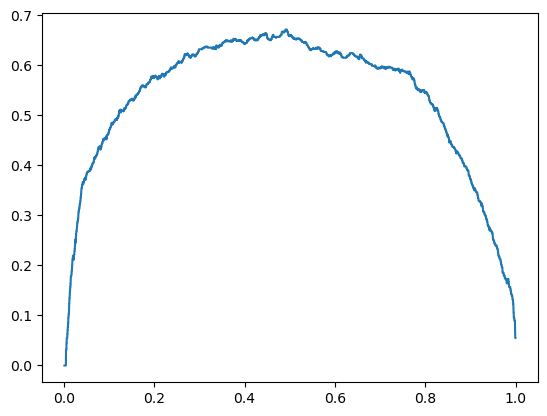

In [50]:
plt.plot(threshs, mat_cors)
plt.show()